In [902]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import datetime
import tensorflow as tf

### Importing data

In [846]:
df = pd.read_csv('data/clean_data.csv')
df.drop('Unnamed: 0',axis=1, inplace=True)
df['obs'] = list(df.index)
df.index = pd.to_datetime(df.Date)

### Feature Engineering

In [852]:
features = pd.read_excel('data/Features.xlsx')
features = features.dropna().iloc[::-1]
features.index = pd.to_datetime(features.Date)
dates = features.index.strftime('%Y-%m-01')
features['Date'] = dates
features.index = pd.to_datetime(dates)
features['2s10s'] = features.yield10y-features.yield2y
features['5s30s'] = features.yield30y-features.yield5y
features.rename({'Date':'feature_date'},axis=1,inplace=True)
features = features.shift(1).dropna().sort_index()
features.head()

,feature_date,fedfunds,yield2y,yield10y,bbb10yspr,HYcdx5y,IGcdx5y,U3rate,yield5y,yield30y,DXYindex,VIX,initialjobless,2s10s,5s30s
Date,,,,,,,,,,,,,,,
2011-10-01,2011-09-01,0.08,0.245,1.916,2.57,87.938,48.549,9.0,0.9518,2.9134,78.553,42.96,405.0,1.671,1.9616
2011-11-01,2011-10-01,0.07,0.240,2.114,2.42,94.000,48.486,8.8,0.9599,3.1307,76.166,29.96,399.0,1.874,2.1708
2011-12-01,2011-11-01,0.08,0.256,2.069,2.59,91.563,47.821,8.6,0.9520,3.0554,78.384,27.80,397.0,1.813,2.1034
2012-01-01,2011-12-01,0.07,0.241,1.877,2.61,92.938,48.478,8.5,0.8318,2.8941,80.178,23.40,376.0,1.636,2.0623
2012-02-01,2012-01-01,0.08,0.217,1.798,2.49,97.375,46.560,8.3,0.7045,2.9375,79.288,19.44,372.0,1.581,2.2330


In [853]:
monthly_df = pd.DataFrame(df.groupby(df.index.strftime('%y/%m')).default.sum())
monthly_df['Date'] = monthly_df.index
monthly_df.index = monthly_df.Date.apply(datetime.datetime.strptime,args=('%y/%m',))
monthly_df['obs'] = range(1,monthly_df.default.count()+1)
monthly_df['month'] = monthly_df.index.month

In [854]:
monthly_df['lag12'] = monthly_df.default.shift(12)
monthly_df['lag1'] = monthly_df.default.shift(1)
monthly_df['ma12'] = monthly_df.default.rolling(12).mean()


model_df = monthly_df.dropna()
model_df = pd.merge(model_df,features,left_index=True,right_index=True)
del model_df['Date']
model_df.head()

,default,obs,month,lag12,lag1,ma12,feature_date,fedfunds,yield2y,yield10y,...,HYcdx5y,IGcdx5y,U3rate,yield5y,yield30y,DXYindex,VIX,initialjobless,2s10s,5s30s
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-01,29,22,10,43.0,22.0,25.166667,2011-09-01,0.08,0.245,1.916,...,87.938,48.549,9.0,0.9518,2.9134,78.553,42.96,405.0,1.671,1.9616
2011-11-01,36,23,11,50.0,29.0,24.000000,2011-10-01,0.07,0.240,2.114,...,94.000,48.486,8.8,0.9599,3.1307,76.166,29.96,399.0,1.874,2.1708
2011-12-01,28,24,12,35.0,36.0,23.416667,2011-11-01,0.08,0.256,2.069,...,91.563,47.821,8.6,0.9520,3.0554,78.384,27.80,397.0,1.813,2.1034
2012-01-01,32,25,1,21.0,28.0,24.333333,2011-12-01,0.07,0.241,1.877,...,92.938,48.478,8.5,0.8318,2.8941,80.178,23.40,376.0,1.636,2.0623
2012-02-01,20,26,2,25.0,32.0,23.916667,2012-01-01,0.08,0.217,1.798,...,97.375,46.560,8.3,0.7045,2.9375,79.288,19.44,372.0,1.581,2.2330


### Visualization / Investigation

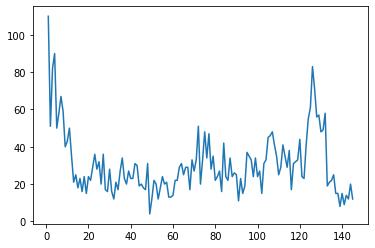

In [605]:
plt.plot(monthly_df.obs,monthly_df.default)

In [855]:
tsa.pacf(monthly_df.default,12)

array([ 1.        ,  0.64345408,  0.33889936,  0.1810516 , -0.20897457,
       -0.03561384,  0.00276801, -0.03434498, -0.1250954 , -0.0877962 ,
        0.00293485,  0.00906027,  0.06754004])

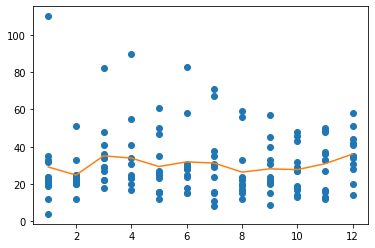

In [604]:
seasonal = monthly_df.groupby('month').default.mean()
plt.plot(monthly_df.month,monthly_df.default,'o')
plt.plot(range(1,13),seasonal.values)

### Linear Model

In [856]:
model_df.columns

Index(['default', 'obs', 'month', 'lag12', 'lag1', 'ma12', 'feature_date',
       'fedfunds', 'yield2y', 'yield10y', 'bbb10yspr', 'HYcdx5y', 'IGcdx5y',
       'U3rate', 'yield5y', 'yield30y', 'DXYindex', 'VIX', 'initialjobless',
       '2s10s', '5s30s'],
      dtype='object')

In [863]:
cols = ['lag1','obs','bbb10yspr','2s10s','U3rate']

In [864]:
model = sm.OLS(model_df.default,\
               model_df[cols]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                default   R-squared (uncentered):                   0.921
Model:                            OLS   Adj. R-squared (uncentered):              0.917
Method:                 Least Squares   F-statistic:                              276.6
Date:                Sun, 27 Feb 2022   Prob (F-statistic):                    9.60e-64
Time:                        17:27:35   Log-Likelihood:                         -444.67
No. Observations:                 124   AIC:                                      899.3
Df Residuals:                     119   BIC:                                      913.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lag1           0.3686      0.080      4.591      0.000       0.210       0.528
obs            0.0461      0.019      2.375      0.019       0.008       0.084
bbb10yspr      7.7456      1.885      4.110      0.000       4.014      11.478
2s10s         -7.4087      1.639     -4.520      0.000     -10.654      -4.163
U3rate         1.6498      0.552      2.989      0.003       0.557       2.743
==============================================================================
Omnibus:                        0.154   Durbin-Watson:                   2.172
Prob(Omnibus):                  0.926   Jarque-Bera (JB):                0.172
Skew:                           0.080   Prob(JB):                        0.918
Kurtosis:                       2.914   Cond. No.                         248.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

962.6774193548387

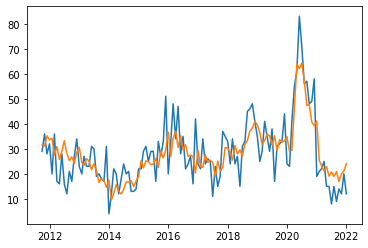

In [938]:
plt.plot(model_df.index,model_df.default)
plt.plot(model_df.index,model.predict(model_df[cols]))
model.mse_total


### PCA Linear Model

In [943]:
from statsmodels.multivariate.pca import PCA
pca_df = model_df.drop(['default','feature_date'],axis=1)
pc = PCA(pca_df,8)
pc.factors
factors = sm.add_constant(pc.factors)
pc_model = sm.OLS(model_df.default,\
                  factors).fit()
pc_model.summary()

/Users/landon/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     23.20
Date:                Mon, 28 Feb 2022   Prob (F-statistic):           8.64e-21
Time:                        13:18:10   Log-Likelihood:                -435.64
No. Observations:                 124   AIC:                             889.3
Df Residuals:                     115   BIC:                             914.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.1129      0.757     37.128      0.000      26.613      29.613
comp_0        27.0183      8.432      3.204      0.002      10.317      43.720
comp_1       -64.9585      8.432     -7.704      0.000     -81.660     -48.257
comp_2        76.7364      8.432      9.101      0.000      60.035      93.438
comp_3       -10.1455      8.432     -1.203      0.231     -26.847       6.556
comp_4        30.0884      8.432      3.569      0.001      13.387      46.790
comp_5        16.6837      8.432      1.979      0.050      -0.018      33.385
comp_6       -30.8301      8.432     -3.656      0.000     -47.532     -14.129
comp_7       -10.9399      8.432     -1.297      0.197     -27.641       5.761
==============================================================================
Omnibus:                        0.229   Durbin-Watson:                   2.336
Prob(Omnibus):                  0.892   Jarque-Bera (JB):                0.115
Skew:                           0.075   Prob(JB):                        0.944
Kurtosis:                       3.011   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

173.74324678730662

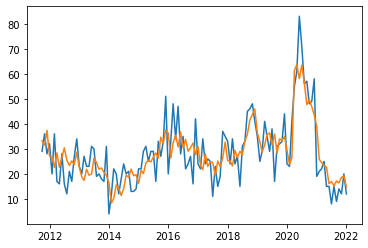

In [944]:
plt.plot(model_df.index,model_df.default)
plt.plot(model_df.index,pc_model.predict(factors))
pc_model.mse_total

#### KNN Model

In [941]:
reg = KNeighborsRegressor(5)
neighbor = reg.fit(model_df[cols],model_df.default)

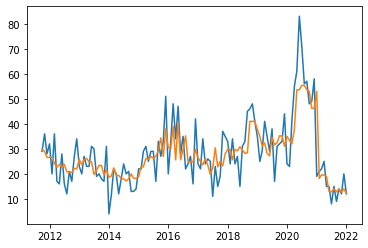

In [942]:
plt.plot(model_df.index,model_df.default)
plt.plot(model_df.index,neighbor.predict(model_df[cols]))


### Tensorflow Models

#### Data Cleaning

In [870]:
# train_df = model_df.sample(frac=0.8)
# test_df = model_df.drop(train_df.index)

factors['default'] = model_df.default
train_df = factors.sample(frac=0.8)
test_df = factors.drop(train_df.index)

In [871]:
train_target = train_df.default.values
# train_feature_tensor = tf.convert_to_tensor(train_df[cols])
train_feature_tensor = tf.convert_to_tensor(train_df.drop('default',axis=1))


test_target = test_df.default.values
# test_feature_tensor = tf.convert_to_tensor(test_df[cols])
test_feature_tensor = tf.convert_to_tensor(test_df.drop('default',axis=1))

In [872]:
normalizer = tf.keras.layers.Normalization(axis=-1)
# normalizer.adapt(train_df[cols])
normalizer.adapt(train_df.drop('default',axis=1))


#### Model Building

In [873]:
net = tf.keras.models.Sequential([
    normalizer,
    # tf.keras.layers.Flatten(input_shape=(len(cols),)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)])

net.compile(optimizer='adam',
            loss=tf.losses.MeanSquaredError())
# metrics=['loss']

In [885]:
net.fit(train_feature_tensor, train_target, epochs=256, batch_size=2)

Epoch 1/256
50/50 [==============================] - 0s 3ms/step - loss: 19.3939
Epoch 2/256
50/50 [==============================] - 0s 2ms/step - loss: 23.9206
Epoch 3/256
50/50 [==============================] - 0s 1ms/step - loss: 25.9342
Epoch 4/256
50/50 [==============================] - 0s 2ms/step - loss: 19.2256
Epoch 5/256
50/50 [==============================] - 0s 2ms/step - loss: 24.3992
Epoch 6/256
50/50 [==============================] - 0s 2ms/step - loss: 20.1655
Epoch 7/256
50/50 [==============================] - 0s 2ms/step - loss: 24.2787
Epoch 8/256
50/50 [==============================] - 0s 2ms/step - loss: 25.6827
Epoch 9/256
50/50 [==============================] - 0s 2ms/step - loss: 18.8154
Epoch 10/256
50/50 [==============================] - 0s 2ms/step - loss: 24.1825
Epoch 11/256
50/50 [==============================] - 0s 2ms/step - loss: 19.3310
Epoch 12/256
50/50 [==============================] - 0s 2ms/step - loss: 22.4890
Epoch 13/256
50/50 [=====

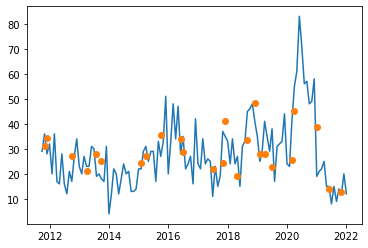

In [886]:
plt.plot(model_df.index,model_df.default)
plt.plot(test_df.index,net.predict(test_feature_tensor),'o')